In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from pybaseball import pitching_stats
from sklearn.linear_model import LinearRegression

In [59]:
from make_password import password  # Import the password function fromm a seperte file
pw = password # insert whatever your database password is here
db = "Statcast"  # Database name
host = "localhost"  # Database host
user = "postgres"  # Database user
port = "5432"  # Database port

def connecting():
    #Establish a connection to the PostgreSQL database.

    connection = None  # Initialize connection variable
    connection = psycopg2.connect(
        database=db,
        host=host,
        user=user,
        password=pw,
        port=port
    )  # Establish connection to the database
    return connection  # Return the connection object

def execute_query(connection, query):
 
    # Execute a SQL query on the database.
    try:
        cursor = connection.cursor()  # Create a cursor object
        cursor.execute(query)  # Execute the SQL query
        connection.commit()  # Commit the transaction
    except psycopg2.Error as e:
        print(f"Error executing query: {e}")  # Print error message
        connection.rollback()  # Rollback the transaction in case of error
    finally:
        cursor.close()  
def read_query(connection, query):
    """
    Execute a SQL query and fetch all results. 
    Returns:
        result (list): List of tuples containing the query results.
    """
    cursor = connection.cursor()  # Create a cursor object
    result = None  # Initialize result variable
    cursor.execute(query)  # Execute the SQL query
    result = cursor.fetchall()  # Fetch all results
    return result  # Return the query results

What is a Whiff?

A whiff in baseball is a very straight forward concept, it's when a batter swings at a pitch and misses. While simple, it is also one of the most important stats in modern baseball. Understanding how and how often pitchers get whiffs is crucial to effectivley evalulate pitchers. A pitcher who is unable to miss bats rarley gets very far in the league. A quick look at the leaderboard for whiffs in 2024 is quite revealing.

In [27]:
# The following code as well as many others in this notebook reference a statcast_2024 database. This was obtained using the pybaseball api and was imported into a postgres database directly in pgadmin4 as the code to do so is quite long and tedious. 
# All CSVS can be found under the CSV folder on github.

get_whiffs = '''SELECT player_name, COUNT(*) as whiff_count
FROM statcast_2024 
WHERE description = 'swinging_strike'
GROUP BY player_name
ORDER BY COUNT(*) DESC;'''

connection = connecting() 
execute_query(connection, get_whiffs) 
whiff_leadder_board = read_query(connection, get_whiffs)
whiff_leadder_board = pd.DataFrame(whiff_leadder_board, columns=['player_name', 'whiff_count'])
print(whiff_leadder_board.head(10))  # Display the top 10 players with the most whiffs



        player_name  whiff_count
0      Cease, Dylan          432
1      Ragans, Cole          424
2     Skubal, Tarik          399
3     Rodón, Carlos          395
4   Peralta, Freddy          389
5    Gilbert, Logan          386
6  Crochet, Garrett          373
7     Wheeler, Zack          371
8      Ober, Bailey          367
9       Sale, Chris          367


Those are some pretty good names topping the leaderboard, including both 2024 AL and NL CY Young winners, as well as a host of elite pitchers. It's pretty obvious a high amount of whiffs is genreally the sign of an elite pitcher. But how well do they correlate with a pitchers run prevention ability, which is the baseline job of a pitcher. For this we will look at whiff rate (simply # of whiffs / # of pitchers) for all qualified  starting pitchers from 2024 and compare to their ERA- (in order to take park factors into account).


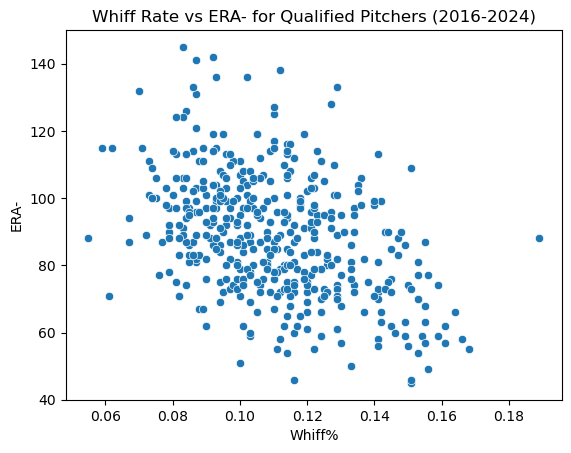

In [29]:
pitching_data=pitching_stats(2016,2024)  
qualified_starters=pitching_data[pitching_data['IP'] >= 162]  # Filter for qualified pitchers
graph_data_starters=qualified_starters[['ERA-', 'SwStr%']]
sns.scatterplot(data=graph_data_starters, x='SwStr%', y='ERA-')
plt.title('Whiff Rate vs ERA- for Qualified Pitchers (2016-2024)')
plt.xlabel('Whiff%')
plt.ylabel('ERA-')
plt.show()

It's very important to note that a 100 ERA- is league average, and the lower a players ERA- the better. So the strong negative correlation we see here supports our hypothesis that whiff rate is an excellent predictor of era.

In [34]:
starters_corr = graph_data_starters['SwStr%'].corr(graph_data_starters['ERA-']).round(2)
print(f' Additionally, the correlation coefficient between whiff rate and ERA- is {starters_corr}, which indicated a moderate correlation between the two variables. Next lets look if this holds true for releivers as well.')

 Additionally, the correlation coefficient between whiff rate and ERA- is -0.43, which indicated a moderate correlation between the two variables. Next lets look if this holds true for releivers as well.


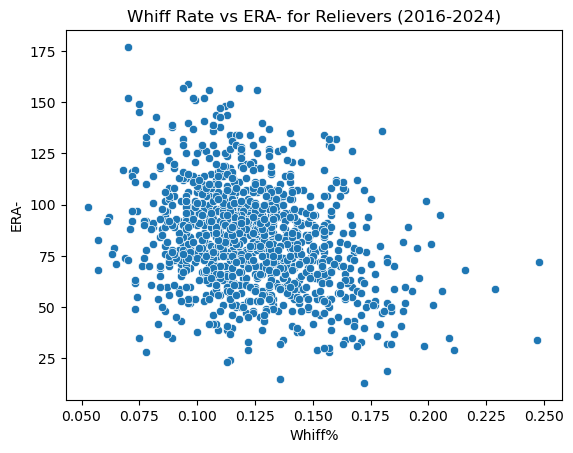

In [43]:
relievers = pitching_stats(2016,2024, qual=50)
actual_relievers=relievers[relievers['GS'] <3]
graph_data_relievers=actual_relievers[['ERA-', 'SwStr%']]
sns.scatterplot(data=graph_data_relievers, x='SwStr%', y='ERA-')
plt.title('Whiff Rate vs ERA- for Relievers (2016-2024)')
plt.xlabel('Whiff%')
plt.ylabel('ERA-')
plt.show()


This graph is a lot more of a blob, but there is still a visible negative correlation between ERA- and Whiff Rate.

In [48]:
releivers_corr = graph_data_relievers['SwStr%'].corr(graph_data_relievers['ERA-']).round(2)
print(f' Additionally, the correlation coefficient between whiff rate and ERA- is {releivers_corr}, which indicated a moderate correlation between the two variables. This is a lot less strong than the correlation we saw with starters, but still shows that whiff rate is a good predictor of run prevention ability for relievers as well.')
print('Part of this is likely due to the fact that releivers have a much smaller sample size than starters and thus are more prone to variance.')

 Additionally, the correlation coefficient between whiff rate and ERA- is -0.28, which indicated a moderate correlation between the two variables. This is a lot less strong than the correlation we saw with starters, but still shows that whiff rate is a good predictor of run prevention ability for relievers as well.
Part of this is likely due to the fact that releivers have a much smaller sample size than starters and thus are more prone to variance.


But showing whiff rates correlates with era,while nice isn't all that important in the grand scheme of things. What would be impressive, is iff we can use whiff rate to predict era in the future. To do so we will be using a lagged regression model. 

WORK ON LATER ONCE I FIGURE OUT WHAT I'M DOING

Next, we'll step away from player analysis and focus more on what ends up getting whiffs, so pitchers can see what works at getting whiffs and plan to implenet those strategies into their arsenal. Let's start by looking at a simple breakdown at what type of pitches get the most whiffs.

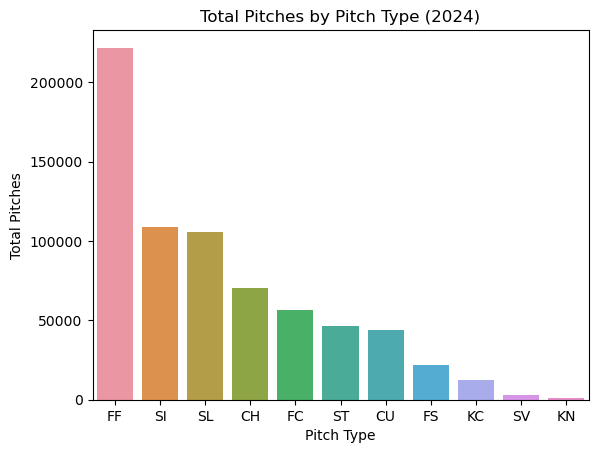

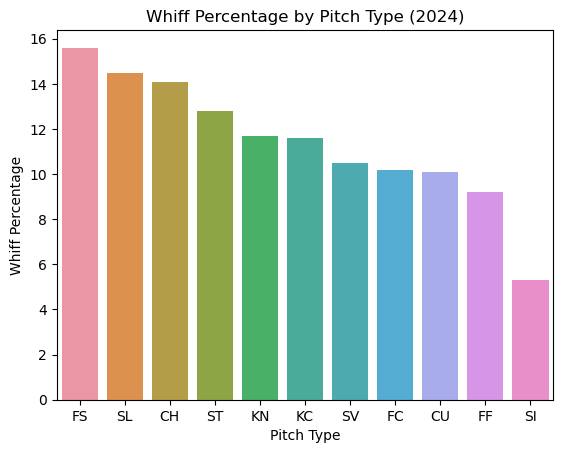

In [67]:
get_pitch_whiff_states='''WITH total_pitches AS (
    SELECT pitch_type, count(*) as total_pitches
    FROM statcast_2024
    GROUP BY pitch_type
	HAVING count(*) >=1000
),
whiffs AS (
    SELECT pitch_type, count(*) as total_whiffs
    FROM statcast_2024
    WHERE description = 'swinging_strike'
    GROUP BY pitch_type
)
SELECT 
    t.pitch_type,
    t.total_pitches,
    COALESCE(w.total_whiffs, 0) as total_whiffs,
    ROUND(COALESCE(w.total_whiffs, 0) * 100.0 / t.total_pitches, 1) as whiff_percentage
FROM total_pitches t
LEFT JOIN whiffs w ON t.pitch_type = w.pitch_type
ORDER BY t.total_pitches DESC;'''

connection = connecting() 
execute_query(connection, get_pitch_whiff_states) 
whiff_by_pitch = read_query(connection, get_pitch_whiff_states)
pitch_whiff_stats= pd.DataFrame(whiff_by_pitch, columns=['pitch_type', 'total_pitches', 'total_whiffs', 'whiff_percentage'])
pitch_whiff_stats = pitch_whiff_stats.sort_values(by='whiff_percentage', ascending=False)
# Total Pitches Plot
pitch_total_stats = pitch_whiff_stats.sort_values(by='total_pitches', ascending=False)
total_pitch_graph = sns.barplot(data=pitch_total_stats, x='pitch_type', y='total_pitches')
total_pitch_graph.set_title('Total Pitches by Pitch Type (2024)')
total_pitch_graph.set_xlabel('Pitch Type')
total_pitch_graph.set_ylabel('Total Pitches')
plt.show()
# Whiff Percentage Plot
whiff_percent_graph = sns.barplot(data=pitch_whiff_stats, x='pitch_type', y='whiff_percentage')
whiff_percent_graph.set_title('Whiff Percentage by Pitch Type (2024)')
whiff_percent_graph.set_xlabel('Pitch Type')
whiff_percent_graph.set_ylabel('Whiff Percentage')
plt.show()



For reference these are what the acronyms stand for

FF-Four Seam Fastball
SI- Sinker
SL- Slider
CH- Changeup
FC- Cutter
ST- Sweeper
CU- Curveball
FS- Splitter
KC- Knuckle Clurve
SV- Slurve
KN- Knuckleball


